In [26]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# 파일 불러오기 예시
import pandas as pd

pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


### TensorFlow

- 수치 계산을 위한 강력한 오픈소스 소프트웨어 라이브러리
- 파이썬으로 수행할 계산 그래프를 정의한 후 C++ 코드를 이용해 효율적으로 실행
- 자동 미분 : 정의한 함수의 그래디언트를 자동으로 계산해줌
- 텐서 보드라는 시각화 도구를 사용해 계산 그래프와 학습 곡선 등을 웹 브라우저로 확인 가능


### 9.1 설치

In [28]:
# 핸즈온은 Tensorflow 1.x로 진행
import tensorflow as tf

tf.__version__

'1.15.0'

## 9.2 첫 번째 계산 그래프를 만들어 세션에서 실행하기

In [29]:
import tensorflow as tf

# 계산 그래프 만드는 과정
x = tf.Variable(3, name='x')
y = tf.Variable(4, name='y')

f = x*x*y + y + 2
f

<tf.Tensor 'add_4:0' shape=() dtype=int32>

In [30]:
# session을 만듦
sess = tf.compat.v1.Session()

# 변수를 초기화
sess.run(x.initializer)
sess.run(y.initializer)

# f를 평가
result = sess.run(f)
print(result) # 3*3*4 + 4 + 2

# Session 닫기
sess.close()

42


In [31]:
# 위와 동일한 코드
with tf.Session() as sess:
    x.initializer.run()  # tf.get_default_session().run(x.initializer)
    y.initializer.run()
    result = f.eval()  # tf.get_default_session().run(f)
    
print(result)

42


- 각 변수를 일일이 초기화하는 대신 `global_variables_initializer()`함수를 사용할 수 있다.

In [32]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # 모든 변수 초기화
    init.run()
    result = f.eval()

print(result)

42


In [33]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)

sess.close()

42


- 텐서플로 프로그램은 두 부분으로 나뉜다.
  - 1. 계산 그래프를 만든다(구성 단계)
  - 2. 만든 그래프를 실행(실행 단계)

## 9.3 계산 그래프 관리

노드를 만들면 자동으로 기본 계산 그래프에 추가된다.

In [34]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

`tf.Graph()`를 이용해 새로운 독립적인 계산 그래프를 만들 수 있으며, 이를 `.as_default()`를 통해 기본 계산 그래프로 사용할 수 있다.

In [35]:
# 기본 그래프를 초기화
tf.reset_default_graph() 

graph = tf.Graph()
with graph.as_default():
    x2 = tf.constant(2)
    print(x2.graph is tf.get_default_graph())  # True
    
print(x2.graph is tf.get_default_graph())  # False
print(x2.graph is graph)  # True

True
False
True


## 9.4 노드 값의 생애주기

In [36]:
w = tf.constant(3)
x = w + 2
y = tf.add(x, 5)
z = x * 3

# 모든 노드의 값은 계산 그래프 실행 간에 유지되지 않는다.
with tf.Session() as sess:
    # 변수값은 유지가 되기 때문에 되도록 변수로 초기화
    # 그렇지 않으면 y, z를 평가할 때 각각 w, x 실행을 해야 한다.
    y_val, z_val = sess.run([y, z])
    print(y_val)  # 10
    print(z_val)  # 15

10
15


## 9.5 텐서플로를 이용한 선형 회귀

### 정규식을 이용한 선형 회귀 풀이

$$
\hat{\mathbf{W}} = \left(\mathbf{X}^{T} \mathbf{X} \right)^{-1} \mathbf{X}^{T} \mathbf{Y} 
$$

In [37]:
import numpy as np
from sklearn.datasets import fetch_california_housing

# 데이터 불러오기
housing = fetch_california_housing()
m, n = housing.data.shape

# 1로 채워진 열 추가
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

print('data shape :', housing.data.shape)
print('data_plus_bias shape :', housing_data_plus_bias.shape)

data shape : (20640, 8)
data_plus_bias shape : (20640, 9)


In [38]:
# 변수 저장
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')  # (20640, 1)

# X의 전치행렬
X_t = tf.transpose(X)

# 정규방정식 실행
weight = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(X_t, X)), X_t), y)

with tf.Session() as sess:
    weight_val = weight.eval()
    
print(weight_val)

[[-3.67372932e+01]
 [ 4.37366009e-01]
 [ 9.47520509e-03]
 [-1.08159676e-01]
 [ 6.48537397e-01]
 [-3.84734449e-06]
 [-3.79239232e-03]
 [-4.19136107e-01]
 [-4.32144403e-01]]


## 9.6 경사 하강법 구현

> 경사 하강법을 사용할 때는 입력 특성 벡터를 정규화(normalization)해주는 것이 중요하다. 그렇지 않으면 학습속도가 매우 느려진다. 

### StandardScaler를 이용한 정규화(normalization)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [40]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### 9.6.1 직접 그래디언트 계산

In [41]:
n_epochs = 1000
learning_rate = 0.01

# 변수 설정
X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W') # random_uniform() : 난수를 담은 텐서를 생성

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(W, W - learning_rate * gradients) # 변수에 새로운 값을 할당하는 노드를 생성

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)

print(best_W)

epoch: 000, MSE = 2.754426
epoch: 100, MSE = 0.632222
epoch: 200, MSE = 0.572780
epoch: 300, MSE = 0.558501
epoch: 400, MSE = 0.549070
epoch: 500, MSE = 0.542288
epoch: 600, MSE = 0.537379
epoch: 700, MSE = 0.533822
epoch: 800, MSE = 0.531243
epoch: 900, MSE = 0.529370
[[ 2.0685523e+00]
 [ 7.7407801e-01]
 [ 1.3119237e-01]
 [-1.1784505e-01]
 [ 1.6477814e-01]
 [ 7.4407691e-04]
 [-3.9194509e-02]
 [-8.6135674e-01]
 [-8.2347983e-01]]


9.6.2 자동 미분 사용

- 대표적인 그래디언트 자동 계산 방식
  - 수치 미분
  - 기호 미분
  - 전진 모드 자동 미분
  - **후진 모드 자동 미분** : 텐서플로가 사용하는 방식(입력이 많고 출력이 적을 때 완벽한 방법)

In [42]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# 위와 다른 부분
# auto-gradients
gradients = tf.gradients(mse, [W])[0]
training_op = tf.assign(W, W - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)

print(best_W)

epoch: 000, MSE = 2.754426
epoch: 100, MSE = 0.632222
epoch: 200, MSE = 0.572780
epoch: 300, MSE = 0.558501
epoch: 400, MSE = 0.549070
epoch: 500, MSE = 0.542288
epoch: 600, MSE = 0.537379
epoch: 700, MSE = 0.533822
epoch: 800, MSE = 0.531243
epoch: 900, MSE = 0.529370
[[ 2.0685523e+00]
 [ 7.7407807e-01]
 [ 1.3119240e-01]
 [-1.1784510e-01]
 [ 1.6477817e-01]
 [ 7.4408413e-04]
 [-3.9194513e-02]
 [-8.6135656e-01]
 [-8.2347965e-01]]


### 9.6.3 Optimizer 사용하기

In [43]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# 위의 코드보다 더 쉬운 방법
# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# 아래 코드도 사용 가능
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)

print(best_W)

epoch: 000, MSE = 2.754426
epoch: 100, MSE = 0.632222
epoch: 200, MSE = 0.572780
epoch: 300, MSE = 0.558501
epoch: 400, MSE = 0.549070
epoch: 500, MSE = 0.542288
epoch: 600, MSE = 0.537379
epoch: 700, MSE = 0.533822
epoch: 800, MSE = 0.531243
epoch: 900, MSE = 0.529370
[[ 2.0685525e+00]
 [ 7.7407807e-01]
 [ 1.3119240e-01]
 [-1.1784507e-01]
 [ 1.6477814e-01]
 [ 7.4408099e-04]
 [-3.9194513e-02]
 [-8.6135662e-01]
 [-8.2347971e-01]]


## 9.7 훈련 알고리즘에 데이터 주입

**플레이스홀더(placeholder)**

- 실제로 아무 계산도 하지 않는 특수한 노드
- 실행 시에 주입한 데이터를 출력하기만 한다.
- 전형적으로 훈련을 하는 동안 텐서플로에 훈련 데이터를 전달하기 위해 사용
- 입력 데이터는 딕셔너리(dictionary)형태로 `session.run()`메소드를 통해 전달된다
- `None`으로 지정되면 이 플레이스홀더는 모든 크기의 데이터를 받을 수 있다.
- 주로 배치단위(`batch size`)의 샘플 데이터 개수에 해당 되는 부분(데이터의 행은 `None`을 사용하고, 데이터 Feature의 길이(데이터의 열)는 고정된 값을 사용한다.

In [44]:
# reset_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: np.array([[4, 5, 6],
                                             [7, 8, 9]])})
    
print('B_val_1:\n{}'.format(B_val_1))
print('B_val_2:\n{}'.format(B_val_2))

B_val_1:
[[6. 7. 8.]]
B_val_2:
[[ 9. 10. 11.]
 [12. 13. 14.]]


### Mini-batch Gradient Descent

In [45]:
# placeholder setting
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")  # (None, 9)
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

################
# hyper-params #
################
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))  # (20640/100) 올림

# mini-batch random sampling
def fetch_batch(epoch, batch_index, batch_size):
    """ epoch당 batch_size만큼 Random sampling 하는 메소드
    
    Args:
        - epoch: training epoch
        - batch_index: batch steps
        - batch_size: batch size
    
    Returns:
        - X_batch, y_batch: batch size만큼의 X, y 데이터셋
    """    
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

# Training
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
    best_W = W.eval()
    
print(best_W)

[[ 2.070016  ]
 [ 0.82045615]
 [ 0.11731729]
 [-0.22739057]
 [ 0.31134027]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.8795008 ]]


## 9.8 모델 저장과 복원

In [46]:
n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y

# loss function
mse = tf.reduce_mean(tf.square(error), name='mse')
# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3)
tf.add_to_collection('weight', W)

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("epoch: {:03d}, MSE = {:.6f}".format(epoch, mse.eval()))
            # 모델 저장
            save_path = saver.save(sess, './model/my_model.ckpt')
        sess.run(training_op)
        
    best_W = W.eval()  # sess.run(W)
    # final 모델 저장
    save_path = saver.save(sess, "./model/my_model_final.ckpt")

print(best_W)

epoch: 000, MSE = 2.754426
epoch: 100, MSE = 0.632222
epoch: 200, MSE = 0.572780
epoch: 300, MSE = 0.558501
epoch: 400, MSE = 0.549070
epoch: 500, MSE = 0.542288
epoch: 600, MSE = 0.537379
epoch: 700, MSE = 0.533822
epoch: 800, MSE = 0.531243
epoch: 900, MSE = 0.529370
[[ 2.0685525e+00]
 [ 7.7407807e-01]
 [ 1.3119240e-01]
 [-1.1784507e-01]
 [ 1.6477814e-01]
 [ 7.4408099e-04]
 [-3.9194513e-02]
 [-8.6135662e-01]
 [-8.2347971e-01]]


### 모델 복원

In [47]:
with tf.Session() as sess:
    # final 모델 복원
    saver.restore(sess, './model/my_model_final.ckpt')
    best_W_restored = tf.get_collection('weight')[0]
    best_W_restored = best_W_restored.eval()
    
# 복원된 값이 일치한지 확인
print(np.allclose(best_W, best_W_restored))  # True

INFO:tensorflow:Restoring parameters from ./model/my_model_final.ckpt
True


## 9.9 TensorBoard로 그래프와 학습 곡선 시각화하기

In [0]:
# TensorFlow Graph visualizer code
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [50]:
show_graph(tf.get_default_graph())

### tfgraphviz 모듈을 이용한 시각화 

이번에는 [`tfgraphviz`](https://github.com/akimach/tfgraphviz) 모듈을 이용해 시각화 해보자.

```bash
$ pip install graphviz # or conda install graphviz
$ pip install tfgraphviz
```

In [55]:
!pip install tfgraphviz

  Created wheel for tfgraphviz: filename=tfgraphviz-0.0.7-cp36-none-any.whl size=4432 sha256=0cc4157ee912c923c229daf312f62d7ab3f910d6ffd24b08d0de02f8081d2fe9
  Stored in directory: /root/.cache/pip/wheels/09/32/14/5a088574d718bfeb86629b01549771914c53a06b4363576b67
Successfully built tfgraphviz


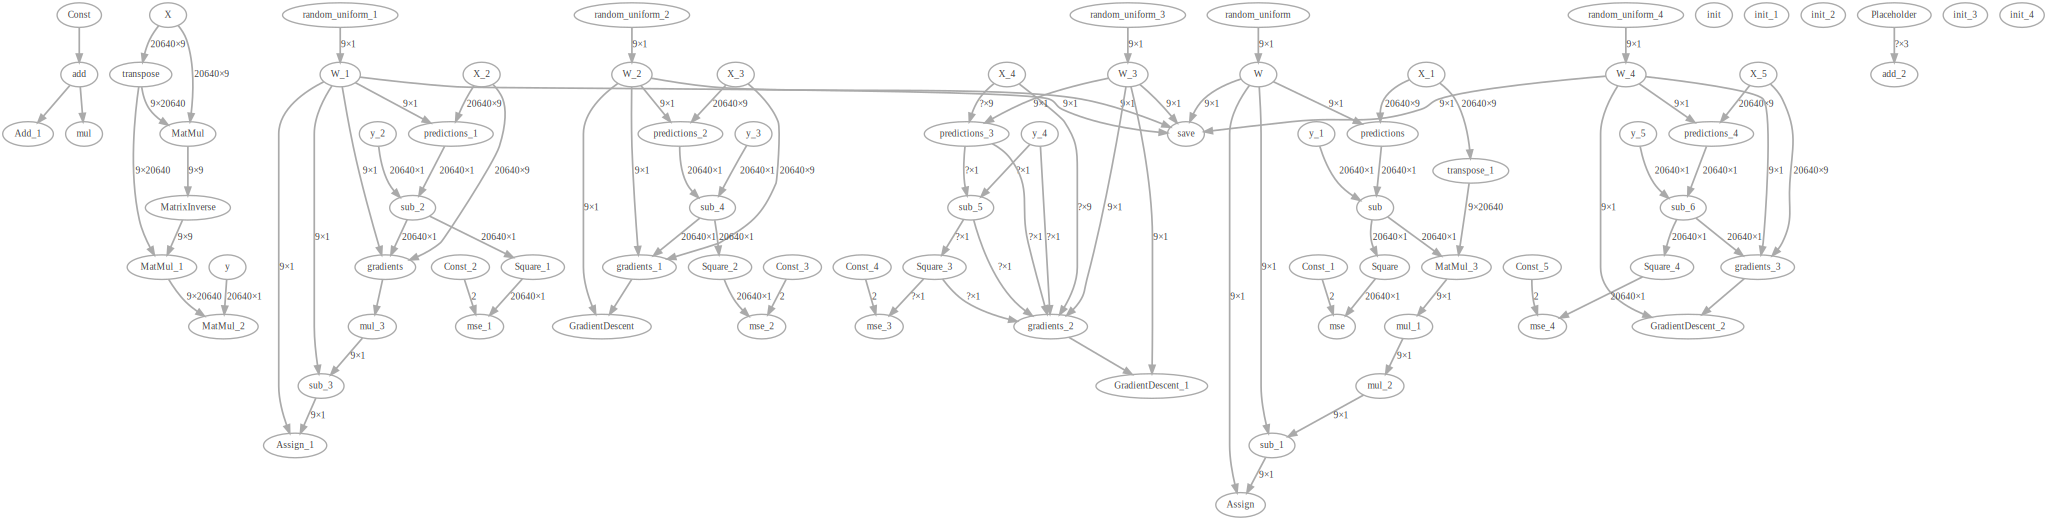

In [56]:
import graphviz

import tfgraphviz as tfg

tf_graph = tfg.board(tf.get_default_graph())
tf_graph

### Using TensorBoard 

In [0]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = 'tf_logs'
logdir = "{}/run-{}".format(root_logdir, now)

In [61]:
# placeholder setting
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")  # (None, 9)
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')

y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b
error = y_pred - y

# loss function
mse = tf.reduce_mean(tf.square(error), name='mse')
# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

# tensorboard에서 요약 정보를 보기위한 설정
mse_summary = tf.summary.scalar('MSE', mse)

################
# hyper-params #
################
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))  # (20640/100) 올림

with tf.Session() as sess:
    sess.run(init)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, 
                                                          y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            
            sess.run(training_op, feed_dict={X: X_batch,
                                             y: y_batch})
            
    best_W = W.eval()
    
print(best_W)

[[ 2.070016  ]
 [ 0.82045615]
 [ 0.11731729]
 [-0.22739057]
 [ 0.31134027]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.8795008 ]]


텐서보드를 사용하려면 Windows 같은 경우 cmd이며, Mac/Linux 인 경우 Terminal에서 아래의 명령어를 입력하면 된다.

```bash
# LOG_DIR: 지정한 로깅 디렉터리
# 위의 예시에서는 ./logs/RNN_with_summaries 로 지정해줌  
tensorboard --logdir=LOG_DIR
```

## 9.10 이름 범위

- 복잡한 그래프를 처리해야 하는 경우 이를 쉽게 추적하고 관리하기 위해서 노드를 이름별로 그룹화하여 묶는 것이 편리 
- `with`구문과 `tf.name_scope('prefix')`를 사용하면 이름 스코프를 사용 가능

아래의 예제는 `c2, c3`를 `prefix_name`이라는 스코프로 그룹화한 것이다. 출력결과를 보면 텐서 객체의 이름 앞에 접두사 형태로 `prefix_name`이 붙은 것을 알 수 있다.

접두사는 그래프를 의미에 따라 서브그래프로 나누고자 할 때 유용하며, 그래프의 구조를 시각화할 때 사용할 수 있다.

In [62]:
with tf.Graph().as_default():
    c1 = tf.constant(4, dtype=tf.float64, name='c')
    with tf.name_scope("prefix_name"):
        c2 = tf.constant(4, dtype=tf.int32, name='c')
        c3 = tf.constant(4, dtype=tf.float64, name='c')

print('c1.name >>', c1.name)
print('c2.name >>', c2.name)
print('c3.name >>', c3.name)

c1.name >> c:0
c2.name >> prefix_name/c:0
c3.name >> prefix_name/c_1:0


In [72]:
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = 'tf_logs'
logdir = "{}/run-{}".format(root_logdir, now)

# placeholder setting
X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")  # (None, 9)
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

W = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name='W')
y_pred = tf.matmul(X, W, name='predictions')  # y = wx + b

# tf.name_scope 적용
with tf.name_scope('loss'):
    error = y_pred - y
    # loss function
    mse = tf.reduce_mean(tf.square(error), name='mse')

# loss/ 접두사 확인
print(error.op.name)
print(mse.op.name)

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

# tensorboard에서 요약 정보를 보기위한 설정
mse_summary = tf.summary.scalar('MSE', mse)
init = tf.global_variables_initializer()

################
# hyper-params #
################
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))  # (20640/100) 올림

with tf.Session() as sess:
    sess.run(init)
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, 
                                                          y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            
            sess.run(training_op, feed_dict={X: X_batch,
                                             y: y_batch})
            
    best_W = W.eval()
    
print(best_W)

loss/sub
loss/mse
[[ 2.070016  ]
 [ 0.82045615]
 [ 0.11731729]
 [-0.22739057]
 [ 0.31134027]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.8795008 ]]


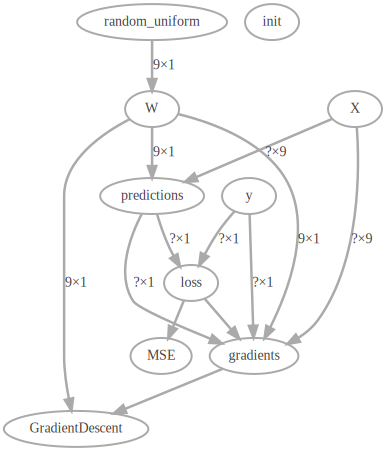

In [73]:
tf_graph = tfg.board(tf.get_default_graph())
tf_graph

## 9.11 모듈화

In [0]:
def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    
        b = tf.Variable(0.0, name="bias")                             
        z = tf.add(tf.matmul(X, w), b, name="z")                      
        return tf.maximum(z, 0., name="max")
    
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

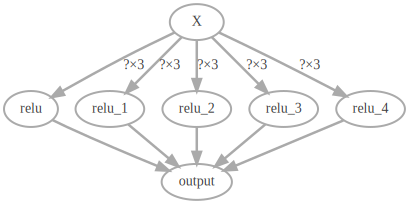

In [77]:
tf_graph = tfg.board(tf.get_default_graph())
tf_graph

## 9.12 변수 공유

In [0]:
def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, relu.threshold, name="max")

### 다른 방법

In [0]:
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

In [0]:
# 변수를 재사용하고 싶을 때 reuse를 True
# 이 코드는 이미 존재하는 relu/threshold 변수를 가져온다.
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [0]:
# 다른 방법
# 변수 범위의 블록 안에서 resue_variable() 메서드를 호출
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [0]:
# 매개변수로 전달하지 않고 threshold 변수를 공유하도록 relu() 함수를 만들기 위한  준비
def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold_")
        w_shape = int(X.get_shape()[1]), 1                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold_", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

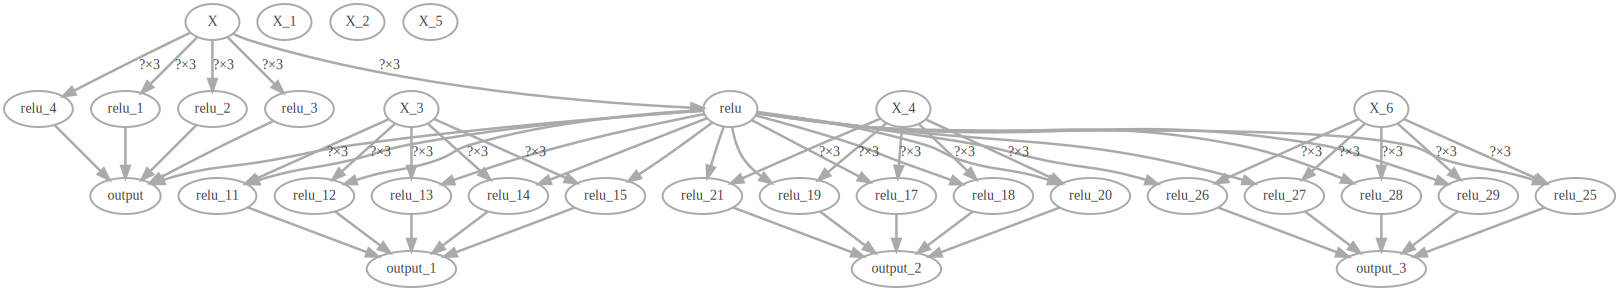

In [90]:
tf_graph = tfg.board(tf.get_default_graph())
tf_graph